In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [7]:
# Base path
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_DIST = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"
GFF_DATA = f"{BASE_DIR}/results/gff_feature_data.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [8]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.set_index('Accession', inplace=True)

# read g4 distribution data
df_dist = pd.read_csv(G4_DIST)
df_dist.set_index('accession', inplace=True)
df_dist = df_dist[['total_g4_length', 'g4_count']]
# rename columns and convert to float
df_dist.columns = ['Total G4 Length', 'G4 Count']
df_dist = df_dist.astype(float)

# read gff data
df_gff = pd.read_csv(GFF_DATA)
df_gff.set_index('accession', inplace=True)
df_gff = df_gff[['gene', 'exon', 'CDS']]
# rename columns and convert to float
df_gff.columns = ['Genes', 'Exons', 'CDS']
df_gff = df_gff.astype(float)

# merge dataframes on index (accession)
df_g4 = df_species.join(df_dist, how='inner')
df_g4 = df_g4.join(df_gff, how='inner')
df_g4.reset_index(inplace=True)
df_g4.rename(columns={'index': 'Accession'}, inplace=True)
df_g4.head()

,Accession,Genome Size,Taxa,Domain,Total G4 Length,G4 Count,Genes,Exons,CDS
0,GCA_000002515.1,10689156,fungi,Eukaryota,11512.0,356.0,7509678.0,35663.0,7394184.0
1,GCA_000002765.3,23292622,protozoa,Eukaryota,15119.0,438.0,13658969.0,118336.0,12451712.0
2,GCA_000006645.1,4701745,bacteria,Bacteria,23973.0,765.0,3916203.0,39060.0,3878552.0
3,GCA_000006605.1,2476822,bacteria,Bacteria,28761.0,909.0,2232019.0,18704.0,2209637.0
4,GCA_000006685.1,1080451,bacteria,Bacteria,4216.0,133.0,988387.0,12072.0,967121.0


In [9]:
# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

# drop rows where gene content is NaN
df_g4 = df_g4.dropna(subset=["Genes"])

# calculate densities per 1Mbp
df_g4['Gene Density'] = df_g4['Genes'] / df_g4["Genome Size"] * 1000000
df_g4['Exon Density'] = df_g4['Exons'] / df_g4["Genome Size"] * 1000000
df_g4['CDS Density'] = df_g4['CDS'] / df_g4["Genome Size"] * 1000000
df_g4['G4 Density'] = df_g4['G4 Count'] / df_g4["Genome Size"] * 1000000

df_g4.head()

,Accession,Genome Size,Taxa,Domain,Total G4 Length,G4 Count,Genes,Exons,CDS,Gene Density,Exon Density,CDS Density,G4 Density
0,GCA_000002515.1,10689156,fungi,Eukaryota,11512.0,356.0,7509678.0,35663.0,7394184.0,702551.071385,3336.371927,691746.289417,33.304781
1,GCA_000002765.3,23292622,protozoa,Eukaryota,15119.0,438.0,13658969.0,118336.0,12451712.0,586407.532823,5080.407006,534577.515576,18.804238
2,GCA_000006645.1,4701745,bacteria,Bacteria,23973.0,765.0,3916203.0,39060.0,3878552.0,832925.435131,8307.553898,824917.557205,162.705549
3,GCA_000006605.1,2476822,bacteria,Bacteria,28761.0,909.0,2232019.0,18704.0,2209637.0,901162.457375,7551.612510,892125.877435,367.002554
4,GCA_000006685.1,1080451,bacteria,Bacteria,4216.0,133.0,988387.0,12072.0,967121.0,914791.138145,11173.111969,895108.616680,123.096744


Text(0.1, 0.9, "Spearman's R: 0.07\np-value: 0.00")

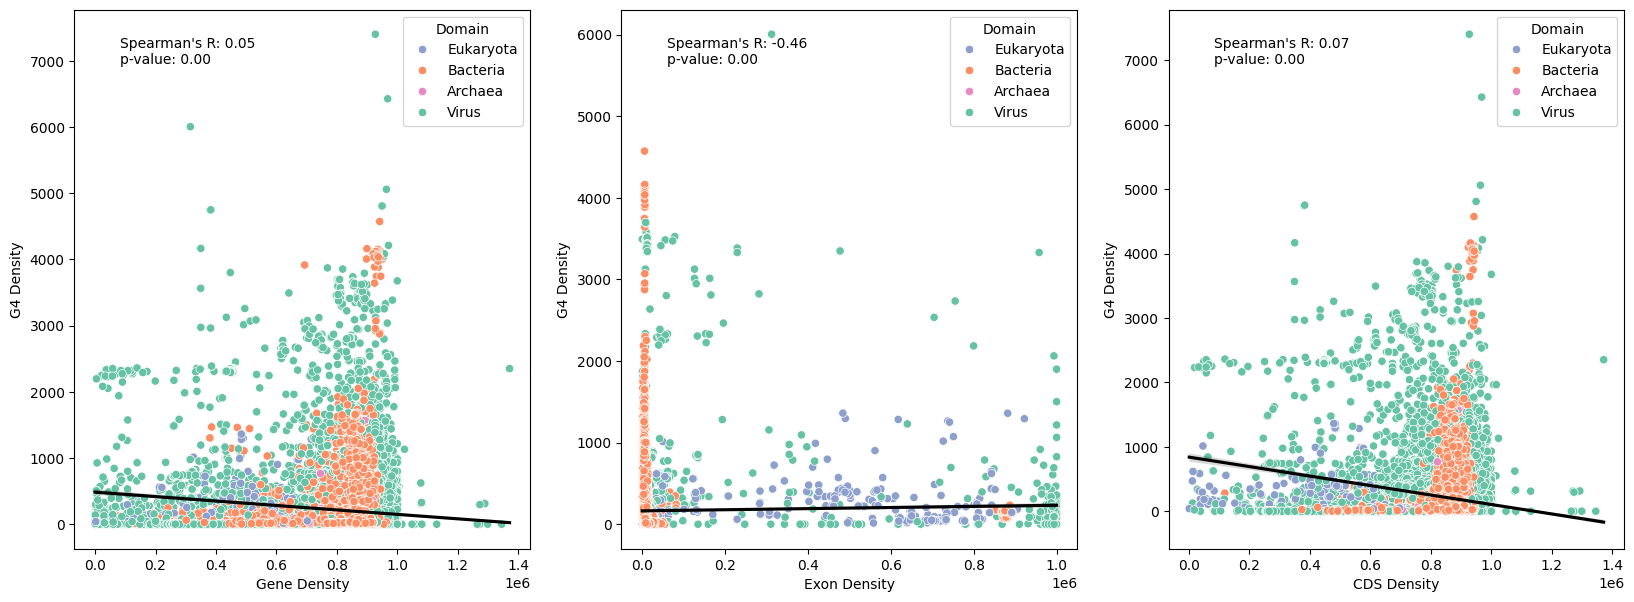

In [10]:
# scatter plot with subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# create new dataframe for exon and cds density with nan values removed
df_g4_exon = df_g4.dropna(subset=['Exon Density'])
df_g4_cds = df_g4.dropna(subset=['CDS Density'])

# plot gene density vs g4 density
sns.scatterplot(
    data=df_g4, 
    x='Gene Density', 
    y='G4 Density', 
    hue='Domain', 
    palette=color_map, 
    ax=ax[0]
)
sns.regplot(
	data=df_g4, 
	x='Gene Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[0]
)
# plot exon density vs g4 density
sns.scatterplot(
	data=df_g4_exon, 
	x='Exon Density', 
	y='G4 Density', 
	hue='Domain', 
	palette=color_map, 
	ax=ax[1]
)
sns.regplot(
	data=df_g4_exon, 
	x='Exon Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[1]
)
# plot cds density vs g4 density
sns.scatterplot(
	data=df_g4_cds, 
	x='CDS Density', 
	y='G4 Density', 
	hue='Domain', 
	palette=color_map, 
	ax=ax[2]
)
sns.regplot(
	data=df_g4_cds, 
	x='CDS Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[2]
)

# display spearman correlation coefficient
gene_corr, gene_p = spearmanr(df_g4['Gene Density'], df_g4['G4 Density'])
exon_corr, exon_p = spearmanr(df_g4_exon['Exon Density'], df_g4_exon['G4 Density'])
cds_corr, cds_p = spearmanr(df_g4_cds['CDS Density'], df_g4_cds['G4 Density'])
ax[0].text(0.1, 0.9, f"Spearman's R: {gene_corr:.2f}\np-value: {gene_p:.2f}", transform=ax[0].transAxes)
ax[1].text(0.1, 0.9, f"Spearman's R: {exon_corr:.2f}\np-value: {exon_p:.2f}", transform=ax[1].transAxes)
ax[2].text(0.1, 0.9, f"Spearman's R: {cds_corr:.2f}\np-value: {cds_p:.2f}", transform=ax[2].transAxes)

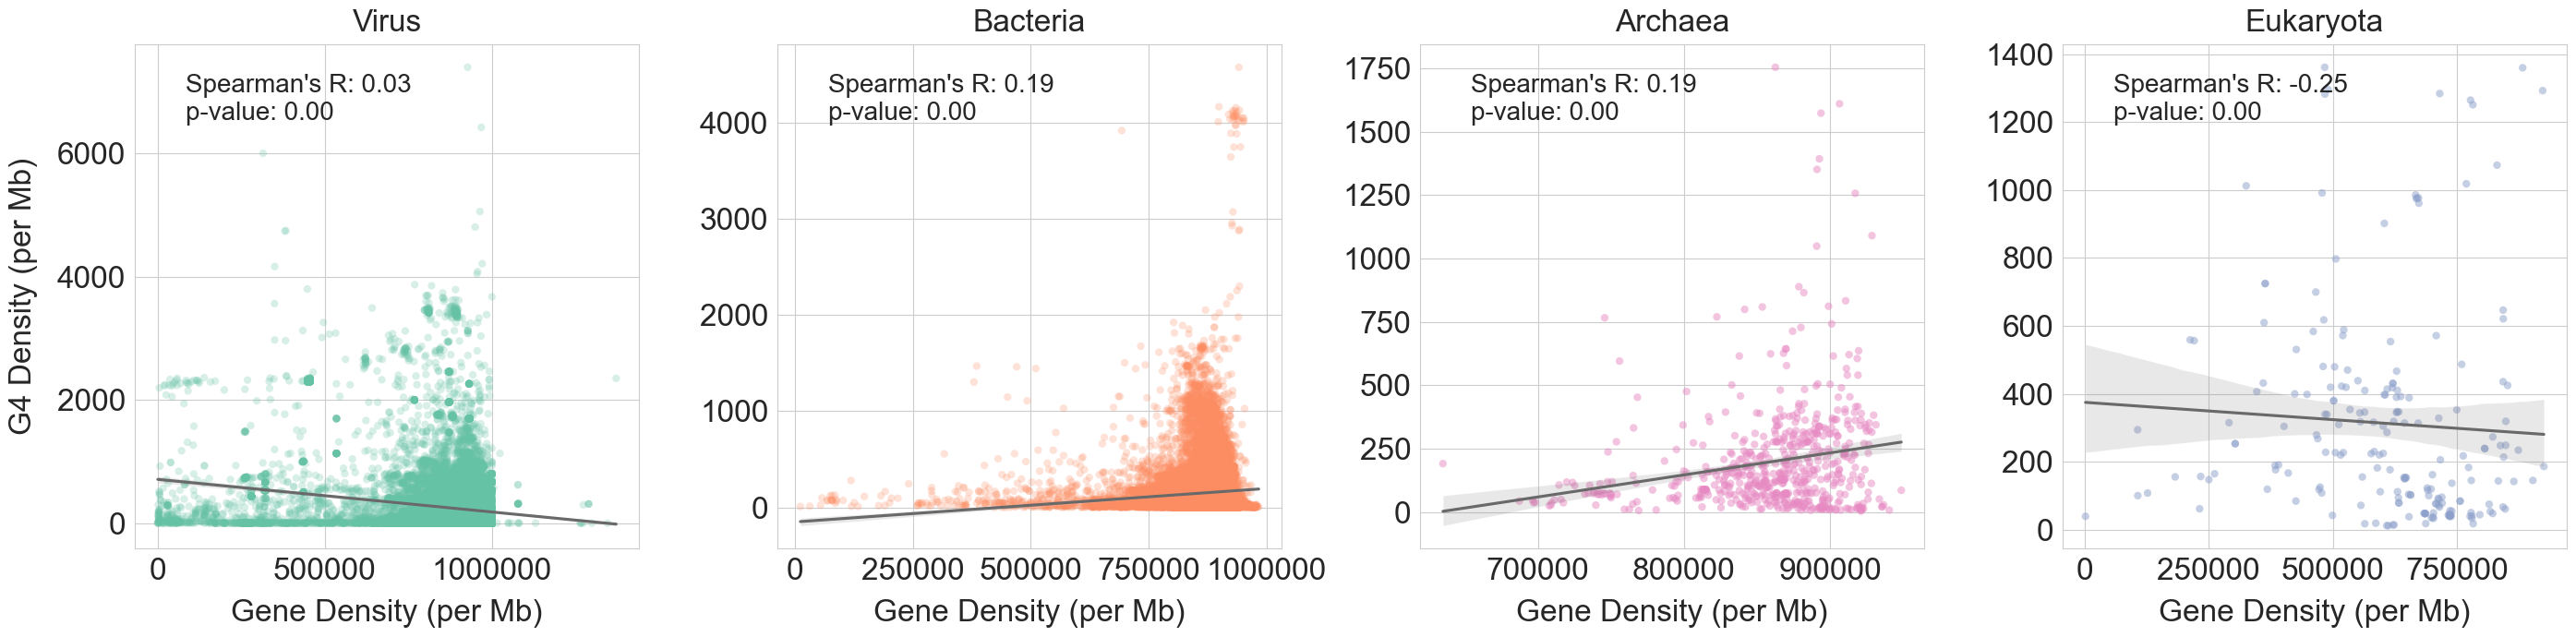

In [12]:
virus_data = df_g4[df_g4['Domain'] == 'Virus']
bacteria_data = df_g4[df_g4['Domain'] == 'Bacteria']
archaea_data = df_g4[df_g4['Domain'] == 'Archaea']
eukaryota_data = df_g4[df_g4['Domain'] == 'Eukaryota']

# plot g4 density vs gene density for each domain
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
sns.scatterplot(
    data=virus_data,
    x="Gene Density",
    y="G4 Density",
    alpha=0.25, edgecolor='none',
    ax=ax[0],
    color=color_map['Virus']
)
sns.regplot(
    data=virus_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[0],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=bacteria_data,
    x="Gene Density",
    y="G4 Density",
    alpha=0.25, edgecolor='none',
    ax=ax[1],
    color=color_map['Bacteria']
)
sns.regplot(
    data=bacteria_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[1],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=archaea_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[2],
    alpha=0.5, edgecolor='none',
    color=color_map['Archaea']
)
sns.regplot(
    data=archaea_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[2],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=eukaryota_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[3],
    alpha=0.5, edgecolor='none',
    color=color_map['Eukaryota']
)
sns.regplot(
    data=eukaryota_data,
    x="Gene Density",
    y="G4 Density",
    ax=ax[3],
    scatter=False,
    color='dimgrey'
)

# set title for each subplot
ax[0].set_title('Virus', fontsize=24, pad=10)
ax[1].set_title('Bacteria', fontsize=24, pad=10)
ax[2].set_title('Archaea', fontsize=24, pad=10)
ax[3].set_title('Eukaryota', fontsize=24, pad=10)

# set axis labels for each subplot
ax[0].set_xlabel('Gene Density (per Mb)', fontsize=24, labelpad=10)
ax[1].set_xlabel('Gene Density (per Mb)', fontsize=24, labelpad=10)
ax[2].set_xlabel('Gene Density (per Mb)', fontsize=24, labelpad=10)
ax[3].set_xlabel('Gene Density (per Mb)', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

# don't use scientific notation for x axis
ax[0].ticklabel_format(style='plain', axis='x')
ax[1].ticklabel_format(style='plain', axis='x')
ax[2].ticklabel_format(style='plain', axis='x')
ax[3].ticklabel_format(style='plain', axis='x')

# display spearman correlation coefficient
virus_corr, virus_p = spearmanr(virus_data['Gene Density'], virus_data['G4 Density'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['Gene Density'], bacteria_data['G4 Density'])
archaea_corr, archaea_p = spearmanr(archaea_data['Gene Density'], archaea_data['G4 Density'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['Gene Density'], eukaryota_data['G4 Density'])
ax[0].text(0.1, 0.85, f"Spearman's R: {virus_corr:.2f}\np-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=20)
ax[1].text(0.1, 0.85, f"Spearman's R: {bacteria_corr:.2f}\np-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=20)
ax[2].text(0.1, 0.85, f"Spearman's R: {archaea_corr:.2f}\np-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=20)
ax[3].text(0.1, 0.85, f"Spearman's R: {eukaryota_corr:.2f}\np-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=20)

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/gene_density_g4_density_domain_g4hunter.png")


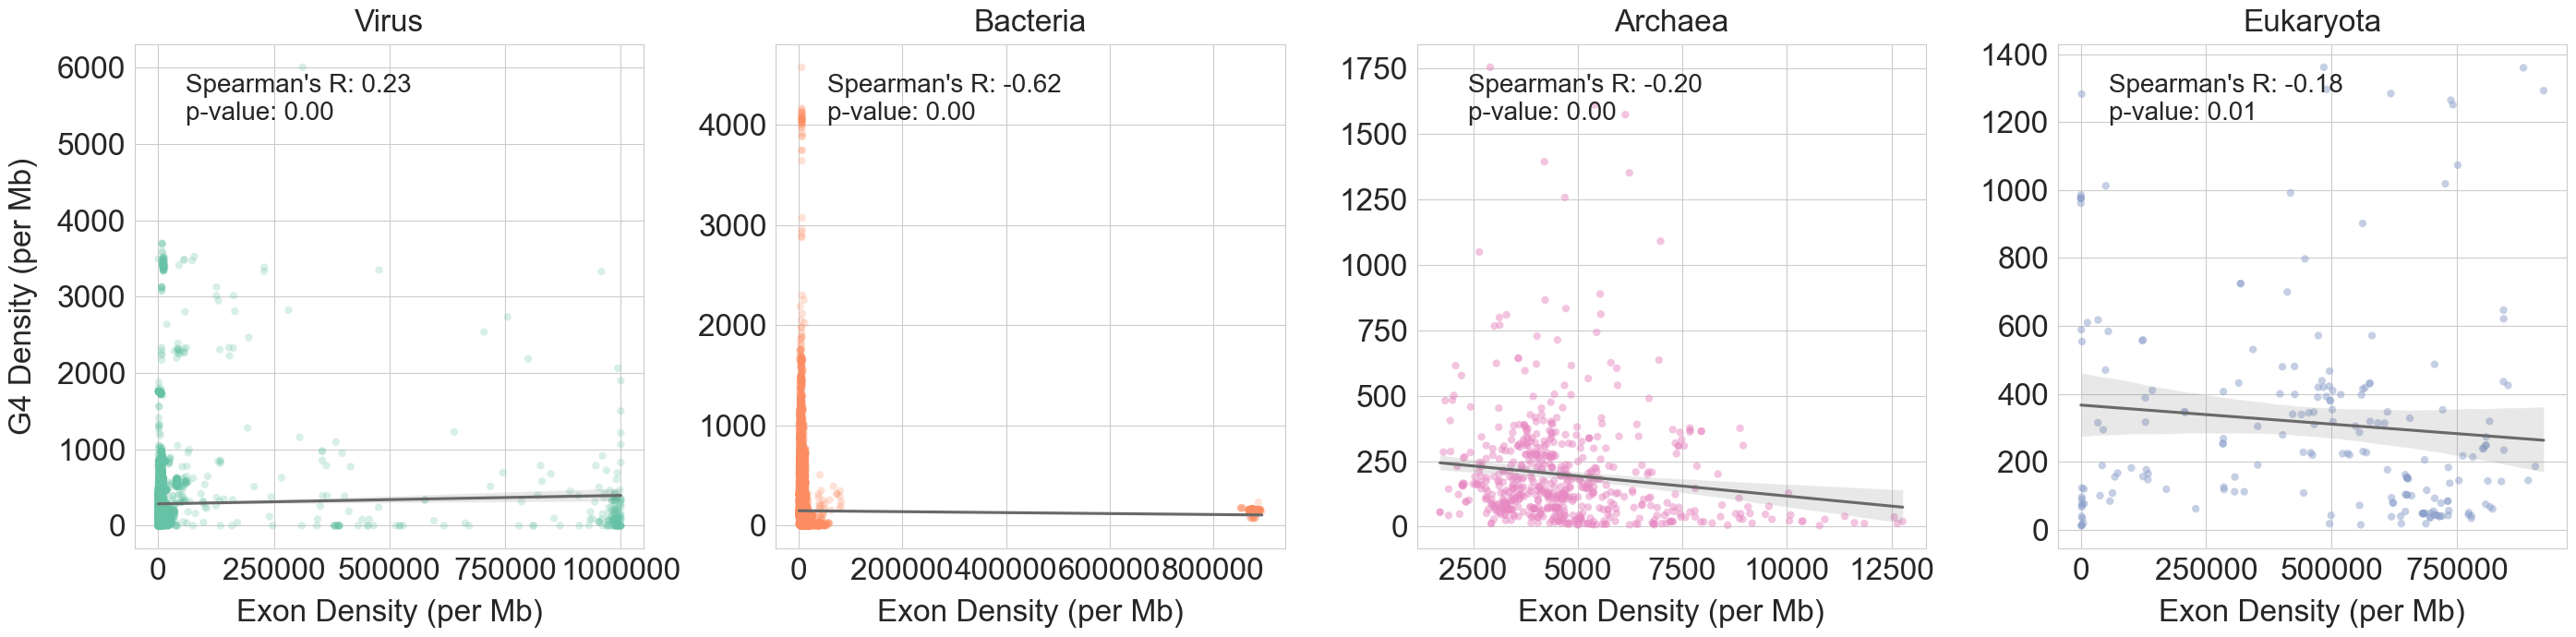

In [13]:
virus_data = df_g4_exon[df_g4_exon['Domain'] == 'Virus']
bacteria_data = df_g4_exon[df_g4_exon['Domain'] == 'Bacteria']
archaea_data = df_g4_exon[df_g4_exon['Domain'] == 'Archaea']
eukaryota_data = df_g4_exon[df_g4_exon['Domain'] == 'Eukaryota']

# plot g4 density vs exon density for each domain
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
sns.scatterplot(
	data=virus_data,
	x="Exon Density",
	y="G4 Density",
	alpha=0.25, edgecolor='none',
	ax=ax[0],
	color=color_map['Virus']
)
sns.regplot(
	data=virus_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[0],
	scatter=False,
	color='dimgrey'
)
sns.scatterplot(
	data=bacteria_data,
	x="Exon Density",
	y="G4 Density",
	alpha=0.25, edgecolor='none',
	ax=ax[1],
	color=color_map['Bacteria']
)
sns.regplot(
	data=bacteria_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[1],
	scatter=False,
	color='dimgrey'
)
sns.scatterplot(
	data=archaea_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[2],
	alpha=0.5, edgecolor='none',
	color=color_map['Archaea']
)
sns.regplot(
	data=archaea_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[2],
	scatter=False,
	color='dimgrey'
)
sns.scatterplot(
	data=eukaryota_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[3],
	alpha=0.5, edgecolor='none',
	color=color_map['Eukaryota']
)
sns.regplot(
	data=eukaryota_data,
	x="Exon Density",
	y="G4 Density",
	ax=ax[3],
	scatter=False,
	color='dimgrey'
)

# set title for each subplot
ax[0].set_title('Virus', fontsize=24, pad=10)
ax[1].set_title('Bacteria', fontsize=24, pad=10)
ax[2].set_title('Archaea', fontsize=24, pad=10)
ax[3].set_title('Eukaryota', fontsize=24, pad=10)

# set axis labels for each subplot
ax[0].set_xlabel('Exon Density (per Mb)', fontsize=24, labelpad=10)
ax[1].set_xlabel('Exon Density (per Mb)', fontsize=24, labelpad=10)
ax[2].set_xlabel('Exon Density (per Mb)', fontsize=24, labelpad=10)
ax[3].set_xlabel('Exon Density (per Mb)', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

# don't use scientific notation for x axis
ax[0].ticklabel_format(style='plain', axis='x')
ax[1].ticklabel_format(style='plain', axis='x')
ax[2].ticklabel_format(style='plain', axis='x')
ax[3].ticklabel_format(style='plain', axis='x')

# display spearman correlation coefficient
virus_corr, virus_p = spearmanr(virus_data['Exon Density'], virus_data['G4 Density'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['Exon Density'], bacteria_data['G4 Density'])
archaea_corr, archaea_p = spearmanr(archaea_data['Exon Density'], archaea_data['G4 Density'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['Exon Density'], eukaryota_data['G4 Density'])
ax[0].text(0.1, 0.85, f"Spearman's R: {virus_corr:.2f}\np-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=20)
ax[1].text(0.1, 0.85, f"Spearman's R: {bacteria_corr:.2f}\np-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=20)
ax[2].text(0.1, 0.85, f"Spearman's R: {archaea_corr:.2f}\np-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=20)
ax[3].text(0.1, 0.85, f"Spearman's R: {eukaryota_corr:.2f}\np-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=20)

plt.tight_layout()

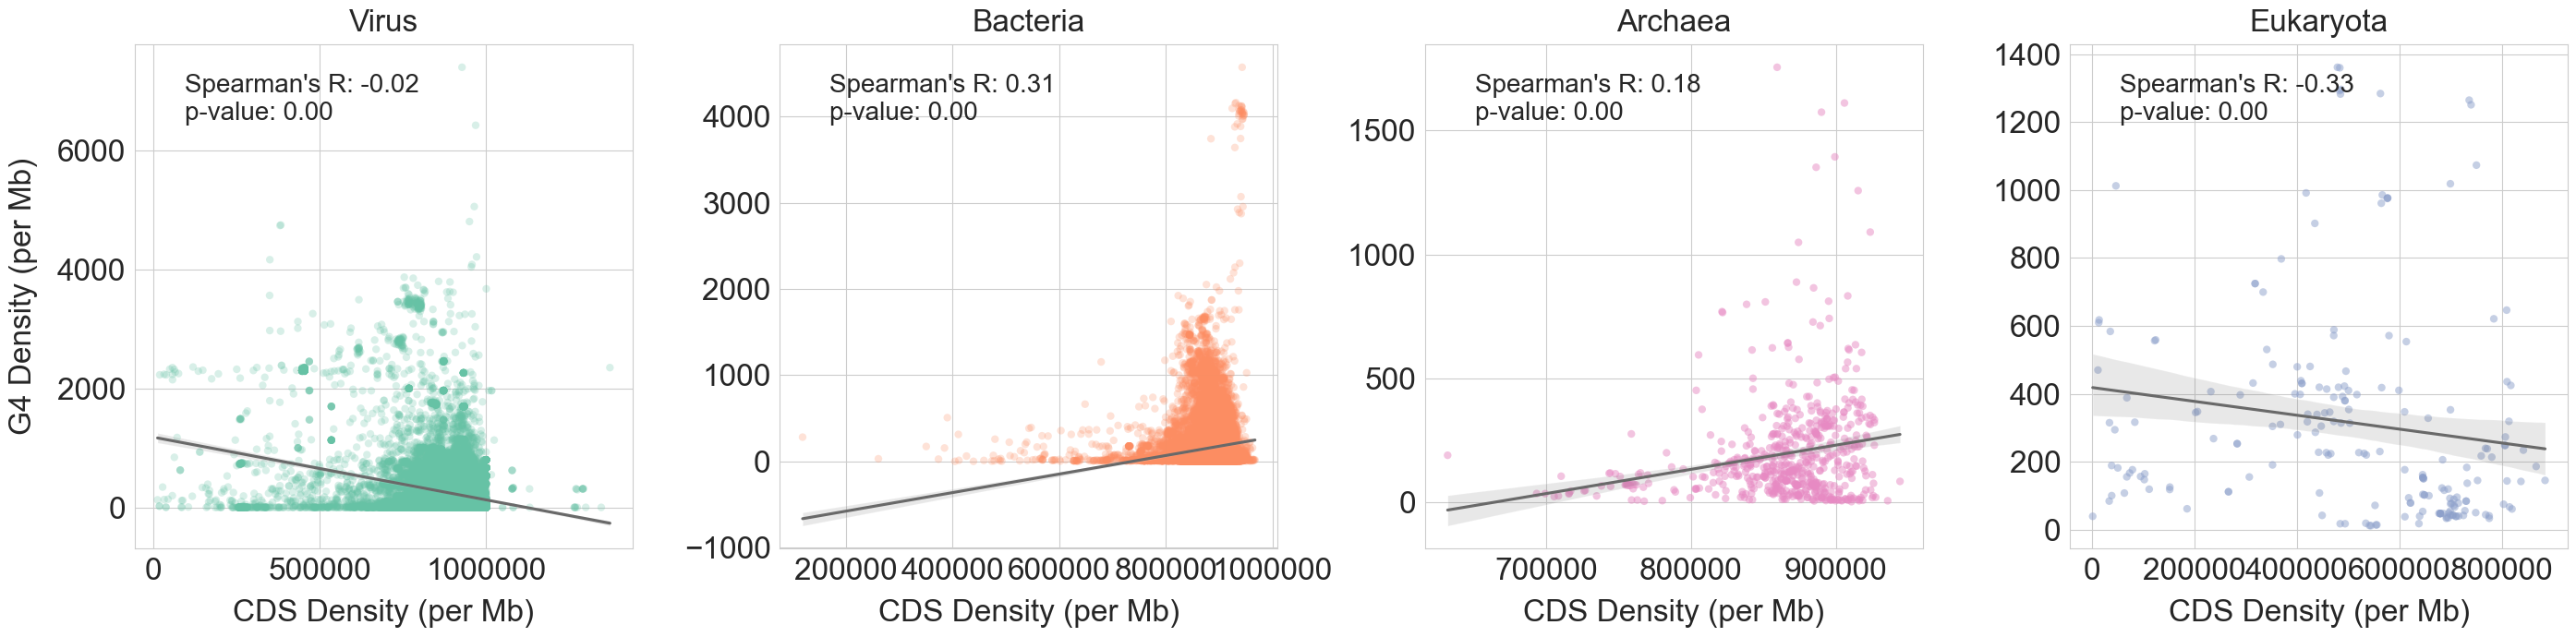

In [14]:
virus_data = df_g4_cds[df_g4_cds['Domain'] == 'Virus']
bacteria_data = df_g4_cds[df_g4_cds['Domain'] == 'Bacteria']
archaea_data = df_g4_cds[df_g4_cds['Domain'] == 'Archaea']
eukaryota_data = df_g4_cds[df_g4_cds['Domain'] == 'Eukaryota']

# plot g4 density vs cds density for each domain
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
sns.scatterplot(
	data=virus_data,
	x="CDS Density",
	y="G4 Density",
	alpha=0.25, edgecolor='none',
	ax=ax[0],
	color=color_map['Virus']
)
sns.regplot(
	data=virus_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[0],
	scatter=False,
	color='dimgrey'
)	
sns.scatterplot(
	data=bacteria_data,
	x="CDS Density",
	y="G4 Density",
	alpha=0.25, edgecolor='none',
	ax=ax[1],
	color=color_map['Bacteria']
)
sns.regplot(
	data=bacteria_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[1],
	scatter=False,
	color='dimgrey'
)
sns.scatterplot(
	data=archaea_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[2],
	alpha=0.5, edgecolor='none',
	color=color_map['Archaea']
)
sns.regplot(
	data=archaea_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[2],
	scatter=False,
	color='dimgrey'
)
sns.scatterplot(
	data=eukaryota_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[3],
	alpha=0.5, edgecolor='none',
	color=color_map['Eukaryota']
)
sns.regplot(
	data=eukaryota_data,
	x="CDS Density",
	y="G4 Density",
	ax=ax[3],
	scatter=False,
	color='dimgrey'
)

# set title for each subplot
ax[0].set_title('Virus', fontsize=24, pad=10)
ax[1].set_title('Bacteria', fontsize=24, pad=10)
ax[2].set_title('Archaea', fontsize=24, pad=10)
ax[3].set_title('Eukaryota', fontsize=24, pad=10)

# set axis labels for each subplot
ax[0].set_xlabel('CDS Density (per Mb)', fontsize=24, labelpad=10)
ax[1].set_xlabel('CDS Density (per Mb)', fontsize=24, labelpad=10)
ax[2].set_xlabel('CDS Density (per Mb)', fontsize=24, labelpad=10)
ax[3].set_xlabel('CDS Density (per Mb)', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

# don't use scientific notation for x axis
ax[0].ticklabel_format(style='plain', axis='x')
ax[1].ticklabel_format(style='plain', axis='x')
ax[2].ticklabel_format(style='plain', axis='x')
ax[3].ticklabel_format(style='plain', axis='x')

# display spearman correlation coefficient
virus_corr, virus_p = spearmanr(virus_data['CDS Density'], virus_data['G4 Density'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['CDS Density'], bacteria_data['G4 Density'])
archaea_corr, archaea_p = spearmanr(archaea_data['CDS Density'], archaea_data['G4 Density'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['CDS Density'], eukaryota_data['G4 Density'])
ax[0].text(0.1, 0.85, f"Spearman's R: {virus_corr:.2f}\np-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=20)
ax[1].text(0.1, 0.85, f"Spearman's R: {bacteria_corr:.2f}\np-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=20)
ax[2].text(0.1, 0.85, f"Spearman's R: {archaea_corr:.2f}\np-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=20)
ax[3].text(0.1, 0.85, f"Spearman's R: {eukaryota_corr:.2f}\np-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=20)

plt.tight_layout()